In [5]:
#Libs
import numpy as np
import tensorflow as tf
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

#Function to draw an image/array
def drawDigit(data : np.ndarray) ->None:
    plt.imshow(data, cmap='gray')
    return

### Import and split Data

In [7]:
#Open Data into (2000,16,15) np.array
Data = np.empty([2000, 16, 15])
with open("nestor files/mfeat-pix.txt", 'r') as file:
    file = file.readlines()
    i = 0
    for line in file:
        k = 0
        l = 0
        for character in line:
            if character.isdigit():
                Data[i][k][l] = float(int(character)/6.0)#read digit and normalize data while reading it in!
                l+=1
                if l == 15:
                    l = 0
                    k+=1
        i+=1
Data.shape

(2000, 16, 15)

In [8]:
Data.min(), Data.max()

(0.0, 1.0)

The last entry should be a 9!


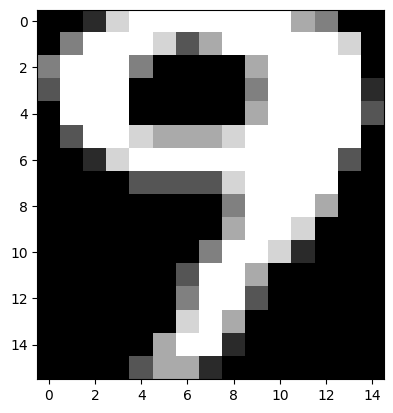

In [9]:
#Example to check it works
drawDigit(Data[-1])
print("The last entry should be a 9!")

### K-Neighearest Neighbor Comparison

In [10]:
# create the labels
labels = np.zeros(2000)

# assign the labels (0-9) to the first 200 instances of each digit
for i in range(10):
    labels[i*200:(i+1)*200] = i

# reshape the data to be 2D
knn_data = Data.reshape(2000, 16 * 15)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(knn_data, labels, test_size=0.2, random_state=69)

# first try k = 3
knn = KNeighborsClassifier(n_neighbors=3)

In [11]:
# train the model
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [12]:
# Predict on the test data
y_pred = knn.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[41  0  0  0  0  0  0  0  0  0]
 [ 0 43  0  0  0  1  0  0  0  0]
 [ 0  0 41  0  0  0  0  0  0  0]
 [ 0  0  0 39  0  0  0  0  0  0]
 [ 0  0  0  0 34  0  1  0  0  0]
 [ 0  0  0  0  0 41  0  0  0  0]
 [ 0  0  0  0  0  1 38  0  0  0]
 [ 0  0  0  0  0  0  0 34  0  0]
 [ 2  0  0  0  0  0  0  0 44  0]
 [ 0  0  0  0  0  0  0  0  0 40]]
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        41
         1.0       1.00      0.98      0.99        44
         2.0       1.00      1.00      1.00        41
         3.0       1.00      1.00      1.00        39
         4.0       1.00      0.97      0.99        35
         5.0       0.95      1.00      0.98        41
         6.0       0.97      0.97      0.97        39
         7.0       1.00      1.00      1.00        34
         8.0       1.00      0.96      0.98        46
         9.0       1.00      1.00      1.00        40

    accuracy                           0.99       400
   macro avg       

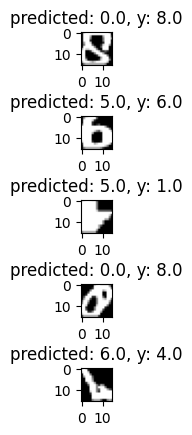

In [13]:
test_size = int(0.2 * 2000)
X_test_draw = X_test.reshape(test_size, 16, 15)

# show digits which were not predicted correctly
wrong_predicts = {}

assert(len(y_test) == len(y_pred))
for idx in range(len(y_test)):
  if y_test[idx] != y_pred[idx]:
    wrong_predicts[idx] = [y_pred[idx], y_test[idx]]

fig = plt.figure()
gs = fig.add_gridspec(len(wrong_predicts), hspace=1.5)
axes = gs.subplots()

count = 0
for key, val in wrong_predicts.items():
  axes[count].imshow(X_test_draw[key], cmap='gray')
  axes[count].set_title(f'predicted: {val[0]}, y: {val[1]}')
  count += 1



### CNN

Steps:<br>
1. Preprocess (reshape, prepare input and create solution vectors)<br>
2. Create architectures<br>
3. Train each Architecture<br>
4. Evaluate each Architecture<br>
5. Compare<br>

#### 1 - Preprocessing

In [14]:
#Split DataSet into Testing and Training Data
TEST_TO_TRAINING_RATIO = 0.2 #SET VALUE!, between 0.0<=x<=1 to set the number of testing and the number of training data. Higher value means higher more testing data but less training!!

#Helps to split the data and create y vectors
test_size = int(2000 * TEST_TO_TRAINING_RATIO)
training_size = 2000 - test_size
cutoff = int(training_size / 10)

#Y vectors
testing_y = np.array([0]*((200-cutoff)) + [1]*(200-cutoff) + [2]*(200-cutoff) + [3]*(200-cutoff) + [4]*(200-cutoff) + [5]*(200-cutoff) + [6]*(200-cutoff) + [7]*(200-cutoff) + [8]*(200-cutoff) + [9]*(200-cutoff))
training_y = np.array([0]*cutoff + [1]*cutoff + [2]*cutoff + [3]*cutoff + [4]*cutoff + [5]*cutoff + [6]*cutoff + [7]*cutoff + [8]*cutoff + [9]*cutoff)

#Set up Numpy arrays
testing_x = np.ndarray((test_size, 16, 15))
training_x = np.ndarray((training_size, 16, 15))

#Tool to loop through Data
test_idx = 0
train_idx = 0

##For every 10 number (0-9). Assign data to either training-or testing data
for i in range(10):
    #There are 200 entries per number
    for k in range(200):
        idx = k + (i*200)
        #If k under a limit, copy into training
        if k < cutoff:
            training_x[train_idx] = Data[idx]
            train_idx += 1
        else:
            testing_x[test_idx] = Data[idx]
            test_idx += 1


print("Training_y shape: ", training_y.shape)
print("Training_x shape: " , training_x.shape)
print("Testing_y shape: " , testing_y.shape)
print("Testing_x shape: " , testing_x.shape)

training_y_cat = tf.keras.utils.to_categorical(training_y)
testing_y_cat = tf.keras.utils.to_categorical(testing_y)

print("\nTraining_y shape: ", training_y_cat.shape)
print("Training_x shape: " , training_x.shape)
print("Testing_y shape: " , testing_y_cat.shape)
print("Testing_x shape: " , testing_x.shape)

Training_y shape:  (1600,)
Training_x shape:  (1600, 16, 15)
Testing_y shape:  (400,)
Testing_x shape:  (400, 16, 15)

Training_y shape:  (1600, 10)
Training_x shape:  (1600, 16, 15)
Testing_y shape:  (400, 10)
Testing_x shape:  (400, 16, 15)


Should be a 9


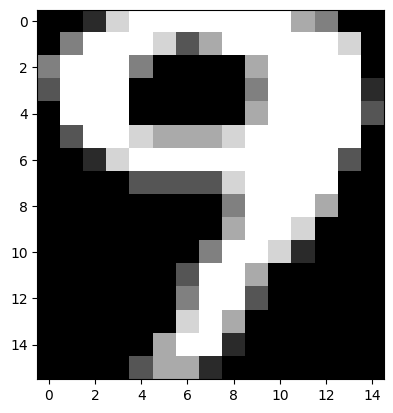

In [15]:
#Test. Should be the same as the first image!
print(f"Should be a {testing_y[-1]}")
drawDigit(testing_x[-1])

#### 2 - Prepare Architectures

A list of models. Create new blocks for each desired model and add them to the list. Let them execute all at once at the end!

In [16]:
model_list = []

##### Convolutional models with 2 conv layers

In [17]:
#Function return a cnn model with 2 conv layer and the given input
def getCNN_2ConvLay(c1_features : int = 6, #number of features in conv layer 1extracted
                 c2_features : int = 16, #number of features in conv layer 2 extracted
                 c_dropout_rate : float = 0.25, #rate of dropout after conv layers
                 f_dropout_rate : float = 0.5,#rate of dropout after fc layers
                 fc_layers : list = []  #list containing integers which represents the number of neurons PER layer.
                 ) -> tf.keras.Sequential:
    if (c1_features < 1 or c2_features < 1) or (c_dropout_rate < 0.0 or c_dropout_rate > 1.0) or (f_dropout_rate < 0.0 or f_dropout_rate > 1.0):
        raise ValueError ("Invalid parameters!")
    layers = [
        tf.keras.layers.Conv2D(c1_features, kernel_size=(3, 3), activation='relu', input_shape=(16,15,1)),
        tf.keras.layers.Conv2D(c2_features, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(c_dropout_rate),
        tf.keras.layers.Flatten(),
    ]
    for lay in fc_layers:
        if type(lay)== int and lay > 0:
                layers.append(tf.keras.layers.Dense(lay, activation='relu'))
    layers.append(tf.keras.layers.Dropout(f_dropout_rate))
    layers.append(tf.keras.layers.Dense(10, activation='softmax'))

    model = tf.keras.Sequential(layers, name="TestModel")
    return model

In [18]:
#Function return a cnn model with 1 conv layer and the given input
def getCNN_1ConvLay(c1_features : int = 20, #number of features in conv layer 1extracted
                 c_dropout_rate : float = 0.25, #rate of dropout after conv layers
                 f_dropout_rate : float = 0.5,#rate of dropout after fc layers
                 fc_layers : list = []  #list containing integers which represents the number of neurons PER layer.
                 ) -> tf.keras.Sequential:
    if (c1_features < 1) or (c_dropout_rate < 0.0 or c_dropout_rate > 1.0) or (f_dropout_rate < 0.0 or f_dropout_rate > 1.0):
        raise ValueError ("Invalid parameters!")
    layers = [
        tf.keras.layers.Conv2D(c1_features, kernel_size=(3, 3), activation='relu', input_shape=(16,15,1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(c_dropout_rate),
        tf.keras.layers.Flatten(),
    ]
    for lay in fc_layers:
        if type(lay)== int and lay > 0:
                layers.append(tf.keras.layers.Dense(lay, activation='relu'))
    layers.append(tf.keras.layers.Dropout(f_dropout_rate))
    layers.append(tf.keras.layers.Dense(10, activation='softmax'))

    model = tf.keras.Sequential(layers, name="TestModel")
    return model

In [19]:
#returns a mlp, given the size of an input layer (NOT SURE IF IT WORKS. ONLY RELEVANT FOR THE MANUAL FEATURE EXTRACTION!!)
def getMLP_0ConvLay(neurons_layer0 : int = 15*16,#number of neurons (and input aswell?? again its not finished and probably not needed)
                    f_dropout_rate : float = 0.5,#rate of dropout after fc layers
                    fc_layers : list = []  #list containing integers which represents the number of neurons PER layer.
                    ) -> tf.keras.Sequential:
    layers = [
        tf.keras.layers.Dense(neurons_layer0, activation = 'relu')
    ]
    for lay in fc_layers:
        if type(lay)== int and lay > 0:
                layers.append(tf.keras.layers.Dense(lay, activation='relu'))
    layers.append(tf.keras.layers.Dropout(f_dropout_rate))
    layers.append(tf.keras.layers.Dense(10, activation='softmax'))
    model = tf.keras.Sequential(layers, name="TestModel")
    return model



In [20]:
model_list.append(getCNN_2ConvLay())

##### CNN's models with one conv layer

#### 3 Train Architectures

In [21]:
#Unknown callback functions
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=20)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")


In [22]:
#model.compile(
#        optimizer=tf.keras.optimizers.RMSprop(),
#        loss=tf.keras.losses.categorical_crossentropy,
#        metrics=['mse', 'accuracy']
#    )

In [23]:
EPOCHS = None
BATCH_SIZE = None

In [24]:
#Fit
history = model_list[0].fit(
    training_x, training_y_cat,
    batch_size=128,
    epochs=20,
    callbacks=[early_stopping_callback, tensorboard_callback],
)


RuntimeError: ignored

#### 4 Test Architectures